<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Recipe-Cuisine-Part-2---Multi-Classification" data-toc-modified-id="Recipe-Cuisine-Part-2---Multi-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Recipe Cuisine Part 2 - Multi Classification</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Related-work" data-toc-modified-id="Related-work-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Related work</a></span></li><li><span><a href="#Known-words-to-remove" data-toc-modified-id="Known-words-to-remove-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Known words to remove</a></span></li><li><span><a href="#Class-Distribution" data-toc-modified-id="Class-Distribution-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Class Distribution</a></span></li><li><span><a href="#Pipelines-and-K-fold-validation-to-compare-text-processing-and-models" data-toc-modified-id="Pipelines-and-K-fold-validation-to-compare-text-processing-and-models-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Pipelines and K-fold validation to compare text processing and models</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Results-of-Logistic-Regression" data-toc-modified-id="Results-of-Logistic-Regression-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Results of Logistic Regression</a></span></li><li><span><a href="#GridSearch-Logistic-Regression" data-toc-modified-id="GridSearch-Logistic-Regression-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>GridSearch Logistic Regression</a></span></li><li><span><a href="#Class-weights-in-loss-function" data-toc-modified-id="Class-weights-in-loss-function-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Class weights in loss function</a></span><ul class="toc-item"><li><span><a href="#Class-weight-balance-testing-scores" data-toc-modified-id="Class-weight-balance-testing-scores-1.6.3.1"><span class="toc-item-num">1.6.3.1&nbsp;&nbsp;</span>Class weight balance testing scores</a></span></li></ul></li></ul></li><li><span><a href="#Oversampling-and-Undersampling" data-toc-modified-id="Oversampling-and-Undersampling-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Oversampling and Undersampling</a></span><ul class="toc-item"><li><span><a href="#Results-on-Over-and-Undersampling" data-toc-modified-id="Results-on-Over-and-Undersampling-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Results on Over and Undersampling</a></span></li></ul></li><li><span><a href="#Calculating-Chi-square-(χ²-)" data-toc-modified-id="Calculating-Chi-square-(χ²-)-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Calculating Chi-square (χ² )</a></span></li><li><span><a href="#Summary-Table" data-toc-modified-id="Summary-Table-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Summary Table</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Deep-Learning-with-Keras---densely-connected-network" data-toc-modified-id="Deep-Learning-with-Keras---densely-connected-network-1.10.1"><span class="toc-item-num">1.10.1&nbsp;&nbsp;</span>Deep Learning with Keras - densely connected network</a></span></li><li><span><a href="#Deep-Learning-with-Keras---Multichannel-n-gram-with-embedding-and-Conv1D" data-toc-modified-id="Deep-Learning-with-Keras---Multichannel-n-gram-with-embedding-and-Conv1D-1.10.2"><span class="toc-item-num">1.10.2&nbsp;&nbsp;</span>Deep Learning with Keras - Multichannel n-gram with embedding and Conv1D</a></span></li><li><span><a href="#Would-more-data-help-with-class-imbalance?" data-toc-modified-id="Would-more-data-help-with-class-imbalance?-1.10.3"><span class="toc-item-num">1.10.3&nbsp;&nbsp;</span>Would more data help with class imbalance?</a></span></li></ul></li></ul></li></ul></div>

# Recipe Cuisine Part 2 - Multi Classification

## Introduction
This notebook continues the recipe classification by handling the multiclass task.  It goes into more detail by comparing different strategies and models - the _Behind the Scenes_ work to help me which model and parameters to choose for deployment in AWS.

Disclaimer: the Summary Table in Section 1.9 contains F1 scores with a different random state value for the train/test split.  They could be slightly off when this notebook is rendered. 

## Related work

Some of the related work I found on recipe cuisine classification based on parsing ingredient text had similiar findings to my work.  
Both of the teams did not have a balanced class dataset.
[This team](http://cs229.stanford.edu/proj2015/313_report.pdf) had the best results with logistic regression due to thier large training set. They found that upsampling the classes with small instance sizes did not yield better results.
[This team](http://jmcauley.ucsd.edu/cse190/projects/fa15/022.pdf) used random forest and had better training scores vs regression on the training set, but overfit as the test results were worse. They had an accuracy score of 77.87% on 39,774 recipes

Neither team reports individual scores for each cuisine, but the overall accuracy on all cuisines.


In [82]:
import pandas as pd
import numpy as np
import ast
import string
import pprint
import nltk
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import cross_validate,StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [83]:
#load the recipes from the DynamoDB CSV exports
indian=pd.read_csv("recipes_indian.csv")
italian=pd.read_csv("recipes_italian.csv")
thai=pd.read_csv("recipes_thai.csv")
chinese=pd.read_csv("recipes_chinese.csv")
french=pd.read_csv("recipes_french.csv")
mexican=pd.read_csv("recipes_mexican.csv")

## Known words to remove
The common remove is from the list of words in the binary class run (from notebook 1, and some extra thrown in based on results I got working with all of the classes)


In [84]:
lemmatizer = WordNetLemmatizer()

#Source for list below
#https://en.wikipedia.org/wiki/Cooking_weights_and_measures
#https://thebakingpan.com/ingredient-weights-and-measures/
measures=['litrbes','liter','millilitres','mL','grams','g', 'kg','teaspoon','tsp', 'tablespoon','tbsp','fluid', 'ounce','oz','fl.oz', 'cup','pint','pt','quart','qt','gallon','gal','smidgen','drop','pinch','dash','scruple','dessertspoon','teacup','cup','c','pottle','gill','dram','wineglass','coffeespoon','pound','lb','tbsp','plus','firmly', 'packed','lightly','level','even','rounded','heaping','heaped','sifted','bushel','peck','stick','chopped','sliced','halves', 'shredded','slivered','sliced','whole','paste','whole',' fresh', 'peeled', 'diced','mashed','dried','frozen','fresh','peeled','candied','no', 'pulp','crystallized','canned','crushed','minced','julienned','clove','head', 'small','large','medium', 'torn', 'cleaned', 'degree']

measures = [lemmatizer.lemmatize(m) for m in measures]
#some of these include data leakage words, like 'italian' 
data_leaks = ['italianstyle', 'french','thai', 'chinese', 'mexican','spanish','indian','italian']

common_remove=['ground','to','taste', 'and', 'or',  'can',  'into', 'cut', 'grated', 'leaf','package','finely','divided','a','piece','optional','inch','needed','more','drained','for','flake','dry','extract','thinly','cubed','bunch','cube','slice','pod','beaten','seeded','uncooked','root','plain','baking','heavy','halved','crumbled','sweet','with','hot','room','temperature','trimmed','allpurpose','deveined','bulk','seasoning','jar','food','if','bag','mix','in','each','roll','instant','double','such','frying','thawed','whipping','stock','rinsed','mild','sprig','freshly','toasted','link','boiling','cooked','unsalted','container',
'cooking','thin','lengthwise','warm','softened','thick','quartered','juiced','pitted','chunk','melted','cold','coloring','puree','cored','stewed','floret','coarsely','the','blanched','zested','sweetened','powdered','garnish','dressing','soup','at','active','lean','chip','sour','long','ripe','skinned','fillet','from','stem','flaked','removed','stalk','unsweetened','cover','crust', 'extra', 'prepared', 'blend', 'of', 'ring',  'undrained', 'about', 'zest', ' ', '', 'spray', 'round', 'herb', 'seasoned', 'wedge', 'bitesize', 'broken', 'square', 'freshly', 'thickly', 'diagonally']
common_remove = [lemmatizer.lemmatize(c) for c in common_remove]
data_leaks = [lemmatizer.lemmatize(d) for d in data_leaks]
# due to using bigrams not including 
useless_singles=['black','white','red','yellow','seed','breast','confectioner','sundried','broth','bell','baby','juice','crumb','sauce','condensed','smoked','basmati','extravirgin','brown','clarified', 'soy', 'filling', 'pine', 'virgin', 'romano', 'heart', 'shell', 'thigh', 'boneless','skinless','split', 'dark', 'wheat', 'light', 'green', 'vegetable', 'curry', 'orange', 'garam', 'sesame', 'strip', 'sea', 'canola', 'mustard','powder', 'ice', 'bay', 'roasted', 'loaf', 'roast', 'powder']
useless_singles = [lemmatizer.lemmatize(u) for u in useless_singles]

In [85]:
def parse_recipes(cuisine, recipe_series):

    for recipe in recipe_series.iteritems():
        ingr_set=ast.literal_eval(recipe[1])
        #print(ingr_set)
        ingr_list=[]
        bigram_list=[]
        for i in ingr_set:
            i.translate(str.maketrans('', '', string.punctuation))
            words=i.split()
            words = [''.join(c for c in word if c not in string.punctuation) for word in words]
            words = [word for word in words if word.isalpha()]
            words = [word.lower() for word in words]
            words = [lemmatizer.lemmatize(word) for word in words]
            words = [word for word in words if word not in measures]

            #first make the bi grams, then remove common words from the single word list
            if(len(words)<3):
                ingr_list.append(' '.join(words))
                ingredients.append(' '.join(words))
            words = [word for word in words if word not in useless_singles]
            for word in words: #not in those single words
                if len(word)>1:
                    ingredients.append(word)
                    ingr_list.append(word)
        #easiest way to deal with any duplicates or blanks for now
            ingr_list=list(set(ingr_list))
            ingr_list = list(filter(None, ingr_list))
#             for bi in bigram_list:
#                 ingredients.append(bi)
        #remove single words here before adding to list of recipe words    
        recipes.append(ingr_list)
        cuisine_labels.append(cuisine)

In [86]:
# print(indian['ingredients'][4])
# recipes[4]


In [87]:
recipes = []
cuisine_labels = []
ingredients = []
bi_ingredients = []
measures.extend(data_leaks)
measures.extend(common_remove)

parse_recipes('indian', indian['ingredients'])
parse_recipes('italian', italian['ingredients'])
parse_recipes('thai', thai['ingredients'])
parse_recipes('chinese', chinese['ingredients'])
parse_recipes('mexican', mexican['ingredients'])
parse_recipes('french', french['ingredients'])

print("Total ingredients {0}, unique ingredients={1} total recipes {2}".format(len(ingredients), len(set(ingredients)),len(recipes)))
fdist = nltk.FreqDist(ingredients)
for word, frequency in fdist.most_common(25):
    print(u'{};{}'.format(word, frequency)) 


Total ingredients 97594, unique ingredients=3647 total recipes 4177
salt;4424
garlic;3991
pepper;3346
onion;3199
oil;2828
tomato;2750
water;2520
cheese;2434
butter;1914
egg;1869
olive;1861
flour;1530
basil;1460
sugar;1394
olive oil;1249
chicken;1218
ginger;1025
oregano;1010
milk;1009
cream;987
parsley;986
white sugar;930
parmesan;846
black pepper;794
parmesan cheese;790


## Class Distribution

['indian', 'italian', 'thai', 'chinese', 'mexican', 'french']
[787, 2520, 148, 260, 75, 387]


Text(0.5, 1.0, 'Cuisine (Class) Counts')

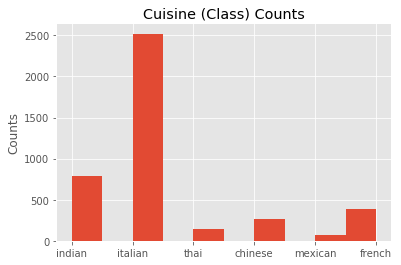

In [88]:
#plot the class counts as a bar chart
from collections import Counter

cuisine_counts = Counter(cuisine_labels)
print(list(cuisine_counts.keys()))
print(list(cuisine_counts.values()))

plt.hist(list(cuisine_counts.keys()), weights=list(cuisine_counts.values()))
plt.ylabel('Counts')
plt.title('Cuisine (Class) Counts')

## Pipelines and K-fold validation to compare text processing and models

Using count vectorizer and parsing single words for ingredients had good results in stage 1.  I ultimately found that using bigrams gave the overall score some lift, and using count vectorizer vs the TFIDF has better results. This was expected based on the related work results and my domain knowledge of some of the cuisines.  Page 4 of [this paper](http://jmcauley.ucsd.edu/cse190/projects/fa15/022.pdf) gives an explanation of why tf idf was worse than count vectorizer.


Random forest overfits the data and Logistic Regression has a better results than Multinomial Naive Bayes due to the increase of data.

I also checked the F1 scores by implementing each model and getting the confusion matrix. Select models and the code are left in cells below.

I changed the `parse_recipes` function to consider helpful two word ingredients into the document string.


In [89]:
pp = pprint.PrettyPrinter(indent=4)

#change the list of lists, to list of strings (docs)
recipe_strings=[]
for r in recipes:
    recipe_strings.append(' '.join(r))

skf=StratifiedKFold(n_splits=3)

#baseline, always guessing the dominant class
dc_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('dc', DummyClassifier(strategy='most_frequent', random_state=123))])

print("results for baseline (most frequent) classifier")
pp.pprint(cross_validate(dc_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))


mnb_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('mnb', MultinomialNB())])

print("\nresults for MNB count vector")
pp.pprint(cross_validate(mnb_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))
        
print("\nresults for LR count vector")
lr_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('lr', LogisticRegression( max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs'))])
pp.pprint(cross_validate(lr_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))

        
print("\nresults for LR tfidf vectorizer")
lr_pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2))), ('lr', LogisticRegression( max_iter=1000,random_state=123, multi_class='multinomial', solver='lbfgs'))])
pp.pprint(cross_validate(lr_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))
#worse testing score with ngram_range=(1, 2)

print("\nresults for RF count vector")
rf_pipe= Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('lr', RandomForestClassifier(n_estimators=100, random_state=123))])
pp.pprint(cross_validate(rf_pipe, recipe_strings, cuisine_labels, scoring='f1_weighted', cv=skf, return_train_score=True ))
#worse testing scores using bigrams


results for baseline (most frequent) classifier


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{   'fit_time': array([0.13163805, 0.12581086, 0.1208148 ]),
    'score_time': array([0.04993701, 0.05122304, 0.04876518]),
    'test_score': array([0.45315067, 0.45420838, 0.45473865]),
    'train_score': array([0.4544734 , 0.4539436 , 0.45367905])}

results for MNB count vector
{   'fit_time': array([0.12551093, 0.12882495, 0.12654281]),
    'score_time': array([0.05675006, 0.0549469 , 0.05268812]),
    'test_score': array([0.83053332, 0.85338998, 0.82204359]),
    'train_score': array([0.92637117, 0.92476411, 0.93012064])}

results for LR count vector
{   'fit_time': array([1.59126902, 1.64240217, 1.6921742 ]),
    'score_time': array([0.05543709, 0.05381012, 0.05640602]),
    'test_score': array([0.85869559, 0.87424467, 0.86979437]),
    'train_score': array([0.99747894, 0.9956827 , 0.99496531])}

results for LR tfidf vectorizer
{   'fit_time': array([1.08867812, 1.0981214 , 1.24694467]),
    'score_time': array([0.05549407, 0.05524564, 0.08937216]),
    'test_score': array([0.8260

In [90]:
# function to use the matplotlib imgshow to create a heatmap confusion matrix
# taken from here https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html and modified

import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
     
    '''
This function is modified to show the color range as normalized to f1 score
both f1 score and class count are printed in the squares
    '''
    
    if normalize:
        cm_normal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(10, 10))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.imshow(cm_normal, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #using the raw cm so the counts are printed on the heat map
    normalize = False
    
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
    thresh = cm_normal.max() / 2.

    for i, j in itertools.product(range(cm_normal.shape[0]), range(cm_normal.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_normal[i, j] > thresh else "black")
        plt.text(j, i+0.25, format(cm_normal[i, j], '.2f'),
         horizontalalignment="center",
         color="white" if cm_normal[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Logistic Regression 

In [91]:
cuisines=cuisine_counts.keys()

#confusion matrix to quantify mistakes were made between cuisines
X_train, X_test, y_train, y_test = train_test_split(recipe_strings, cuisine_labels, test_size=0.25, stratify=cuisine_labels, random_state=123)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


vectorizer = CountVectorizer(ngram_range=(1, 2))

# tokenize and build vocab
matrix_train=vectorizer.fit_transform(X_train)
matrix_test=vectorizer.transform(X_test)
# print(matrix_train[:5])
lr_clf = LogisticRegression( max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs')
lr_clf.fit(matrix_train, y_train)

y_pred = lr_clf.predict(matrix_test)



print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))#,target_names=cuisines))
cm_lr_test=confusion_matrix(y_test, y_pred)
print(cm_lr_test)

 

print("results of using the LR model on the training data:")
y_pred_train = lr_clf.predict(matrix_train)
print('accuracy %s' % accuracy_score(y_pred_train, y_train))
print(classification_report(y_train, y_pred_train))#,target_names=cuisines))
cm_lr_train = confusion_matrix(y_train, y_pred_train)
print(cm_lr_train)

#What was misclassified in the test and train set?
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, y_pred):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the test set:**\n")
for m in misclassifiedIndexes[:10]:
#     if(y_test[m]=='mexican' and y_pred[m]=='italian'):
    print("{0} classified as {1}:\n{2}\n".format(y_test[m],y_pred[m],X_test[m]))


index = 0
misclassifiedIndexes = []
for label, predict in zip(y_train, y_pred_train):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print("\n**misclassified in the train set:**\n")
for m in misclassifiedIndexes[:5]:
    print("{0} classified as {1}:\n{2}\n".format(y_train[m],y_pred_train[m],X_train[m])) 
    

accuracy 0.8918660287081339
              precision    recall  f1-score   support

     chinese       0.84      0.74      0.79        65
      french       0.75      0.54      0.63        97
      indian       0.96      0.93      0.94       197
     italian       0.89      0.97      0.93       630
     mexican       1.00      0.58      0.73        19
        thai       0.79      0.70      0.74        37

    accuracy                           0.89      1045
   macro avg       0.87      0.74      0.79      1045
weighted avg       0.89      0.89      0.89      1045

[[ 48   1   1  10   0   5]
 [  1  52   1  43   0   0]
 [  2   1 183   9   0   2]
 [  3  13   2 612   0   0]
 [  0   1   0   7  11   0]
 [  3   1   4   3   0  26]]
results of using the LR model on the training data:
accuracy 0.9955300127713921
              precision    recall  f1-score   support

     chinese       1.00      1.00      1.00       195
      french       1.00      0.98      0.99       290
      indian       0.99

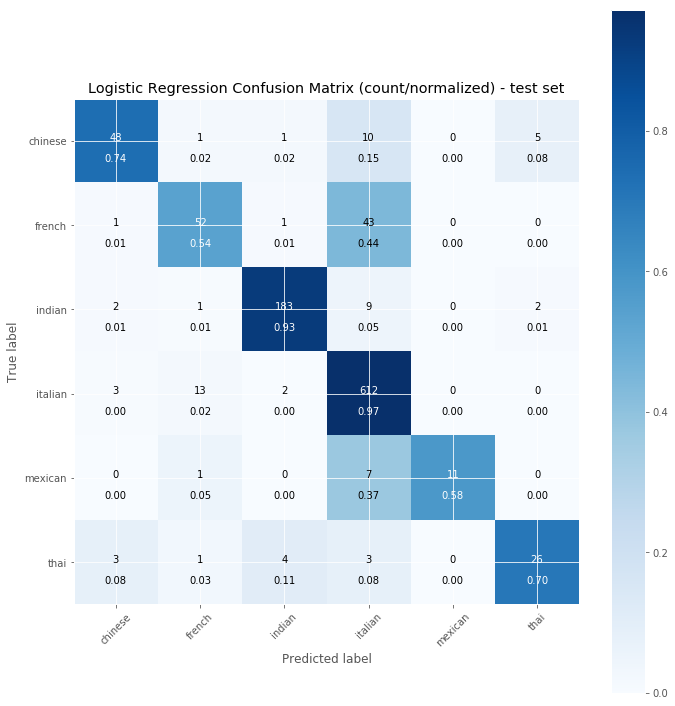

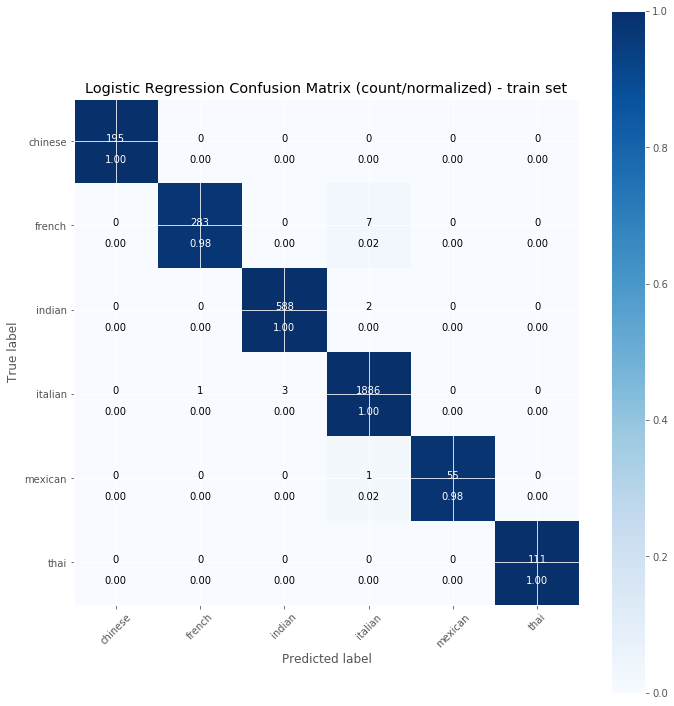

In [92]:
classes=['chinese', 'french','indian','italian','mexican','thai' ]

plot_confusion_matrix(cm_lr_test, classes=classes, normalize=True, title="Logistic Regression Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_train, classes=classes, normalize=True, title="Logistic Regression Confusion Matrix (count/normalized) - train set")

### Results of Logistic Regression

As the data size grows, [Logistic Regression performs better than Naive Bayes](http://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf). This is also true for the recipe dataset.
Looking at the individual scores for each cuisine, there is overfitting, and it is not clear if class imbalance is a problem.  For example, there are 75 total Mexican recipes (0.73), while there are 387 French recipes (0.63).

Some things to observe:


-   French mostly gets misclassified most as Italian, 
- Mexican gets misclasified most as Italian
-   Thai as gets misclassified as Chinese followed by Indian. 
- Mexican as Italian is slightly unexpected but I can see why in the printed cases.

### GridSearch Logistic Regression
Would other hyperparamter values give better results? No, the result I get are the defaults for Logistic Regression (close for the C value)
- Best Penalty: l2
- Best C: 1.5

In [93]:

penalty = ['l1', 'l2']

C = [0.001,0.01,0.1,1,1.5,2,5,10,100]

# note even with ngram_range=(1, 2), the chosen hyperparamters are the same
lr_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))), ('lr', LogisticRegression(max_iter=1000,random_state=123, multi_class='auto', ))])
# Create hyperparameter options
hyperparameters = dict(lr__C=C, lr__penalty=penalty )
#logistic = LogisticRegression(  multi_class='multinomial')
clf = GridSearchCV(lr_pipe, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(recipe_strings, cuisine_labels)
print('Best Penalty:', best_model.best_estimator_.get_params()['lr__penalty'])
print('Best C:', best_model.best_estimator_.get_params()['lr__C'])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Penalty: l2
Best C: 2


### Class weights in loss function
The `class_weight='balanced'` argument will weigh classes inversely proportional to their frequency.

In [94]:
vectorizer = CountVectorizer(ngram_range=(1, 2))

# tokenize and build vocab
#vectorizer.fit_transform(recipe_strings)
matrix_train=vectorizer.fit_transform(X_train)
matrix_test=vectorizer.transform(X_test)

lr_balance = LogisticRegression( class_weight='balanced',penalty='l2', multi_class='auto', C=2, max_iter=1000, random_state=123, solver='lbfgs')

lr_balance.fit(matrix_train, y_train)

y_pred = lr_balance.predict(matrix_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))#,target_names=cuisines))
cm_lr_balance_test = confusion_matrix(y_test, y_pred)
print(cm_lr_balance_test)


print("results of using the LR model on the training data:")
y_pred_train = lr_balance.predict(matrix_train)
print('accuracy %s' % accuracy_score(y_pred_train, y_train))
print(classification_report(y_train, y_pred_train))#,target_names=cuisines))
cm_lr_balance_train = confusion_matrix(y_train, y_pred_train)
print(cm_lr_balance_train)


accuracy 0.877511961722488
              precision    recall  f1-score   support

     chinese       0.77      0.78      0.78        65
      french       0.58      0.66      0.62        97
      indian       0.94      0.94      0.94       197
     italian       0.93      0.91      0.92       630
     mexican       0.94      0.79      0.86        19
        thai       0.72      0.70      0.71        37

    accuracy                           0.88      1045
   macro avg       0.81      0.80      0.80      1045
weighted avg       0.88      0.88      0.88      1045

[[ 51   1   1   7   0   5]
 [  2  64   1  29   1   0]
 [  3   1 185   4   0   4]
 [  7  41   5 576   0   1]
 [  0   2   0   2  15   0]
 [  3   2   4   2   0  26]]
results of using the LR model on the training data:
accuracy 0.9955300127713921
              precision    recall  f1-score   support

     chinese       1.00      1.00      1.00       195
      french       0.97      1.00      0.98       290
      indian       0.99 

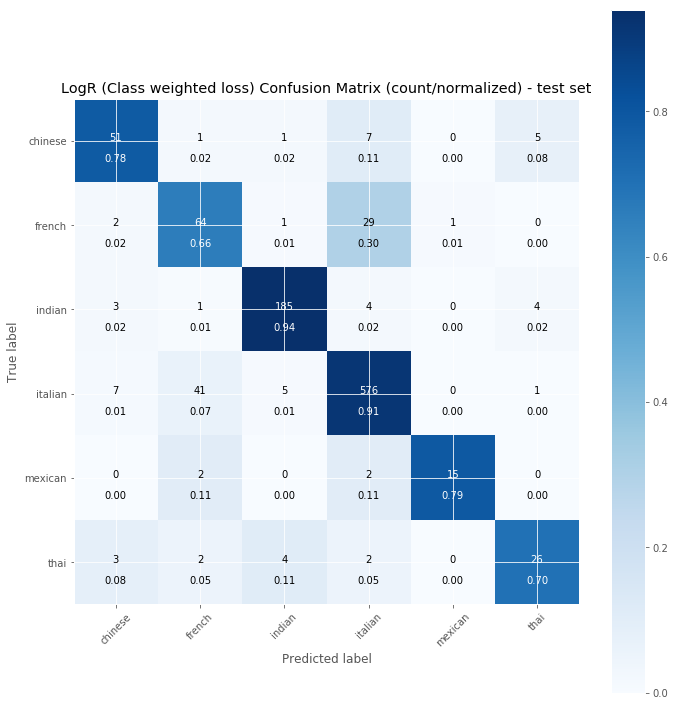

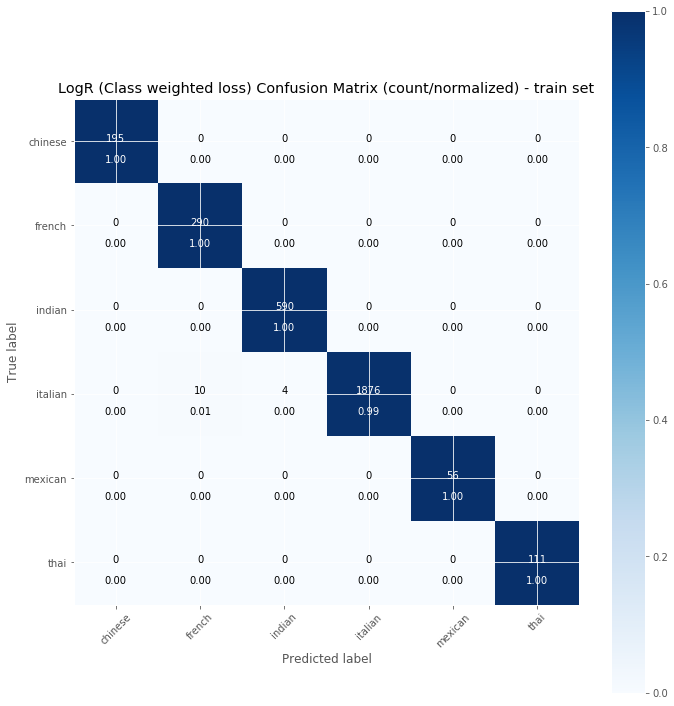

In [95]:
plot_confusion_matrix(cm_lr_balance_test, classes=classes, normalize=True, title="LogR (Class weighted loss) Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_balance_train, classes=classes, normalize=True, title="LogR (Class weighted loss) Confusion Matrix (count/normalized) - train set")

#### Class weight balance testing scores
There is some lift with the classes that did not do as well.  Most significant is Mexican from .69 to .79.


**Before class weights:**       
        
              precision    recall  f1-score   support

     chinese       0.86      0.77      0.81        65
      french       0.73      0.48      0.58        97
      indian       0.97      0.93      0.95       197
     italian       0.88      0.97      0.93       630
     mexican       1.00      0.53      0.69        19
        thai       0.79      0.73      0.76        37
        
        
**After:**

              precision    recall  f1-score   support

     chinese       0.85      0.78      0.82        65
      french       0.69      0.61      0.65        97
      indian       0.96      0.93      0.95       197
     italian       0.91      0.96      0.94       630
     mexican       0.93      0.68      0.79        19
        thai       0.82      0.73      0.77        37 

## Oversampling and Undersampling

I used a Python package called [Imbalance learn](https://imbalanced-learn.readthedocs.io/en/stable/) to implement over and undersampling, and find out if how much this would help or not help the scores of the cuisines.


In [96]:
# create a dictionary, to pandas dataframe, to randomly sample by a fixed size

recipe_dict = {'recipe_words':recipe_strings, 'cuisine':cuisine_labels}

recipe_df = pd.DataFrame(recipe_dict, columns=['recipe_words','cuisine'])

X_train, X_test, y_train, y_test = train_test_split(recipe_df['recipe_words'], recipe_df['cuisine'], test_size=0.25, stratify=recipe_df['cuisine'], random_state=123)


from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


lr_pipe_os = pl.make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                           RandomOverSampler(random_state=123),
                           LogisticRegression(max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs'))


# Train the classifier with balancing
lr_pipe_os.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = lr_pipe_os.predict(X_test)

print("results on oversampling:\n")
# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))
y_pred_train_bal = lr_pipe_os.predict(X_train)
print(classification_report_imbalanced(y_train, y_pred_train_bal))

cm_lr_os_test = confusion_matrix(y_test, y_pred_bal)
cm_lr_os_train = confusion_matrix(y_train, y_pred_train_bal)



lr_pipe_us = pl.make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                           RandomUnderSampler(random_state=123),
                           LogisticRegression(max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs'))


print("results on undersampling:\n")
# Train the classifier with balancing
lr_pipe_us.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = lr_pipe_us.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))
y_pred_train_bal = lr_pipe_us.predict(X_train)
print(classification_report_imbalanced(y_train, y_pred_train_bal))

cm_lr_us_test = confusion_matrix(y_test, y_pred_bal)
cm_lr_us_train = confusion_matrix(y_train, y_pred_train_bal)



results on oversampling:

                   pre       rec       spe        f1       geo       iba       sup

    chinese       0.79      0.75      0.99      0.77      0.86      0.73        65
     french       0.60      0.64      0.96      0.62      0.78      0.59        97
     indian       0.94      0.94      0.99      0.94      0.96      0.92       197
    italian       0.92      0.92      0.88      0.92      0.90      0.82       630
    mexican       0.94      0.79      1.00      0.86      0.89      0.77        19
       thai       0.72      0.70      0.99      0.71      0.83      0.68        37

avg / total       0.88      0.88      0.92      0.88      0.90      0.81      1045

                   pre       rec       spe        f1       geo       iba       sup

    chinese       1.00      1.00      1.00      1.00      1.00      1.00       195
     french       0.98      1.00      1.00      0.99      1.00      1.00       290
     indian       0.99      1.00      1.00      1.00     

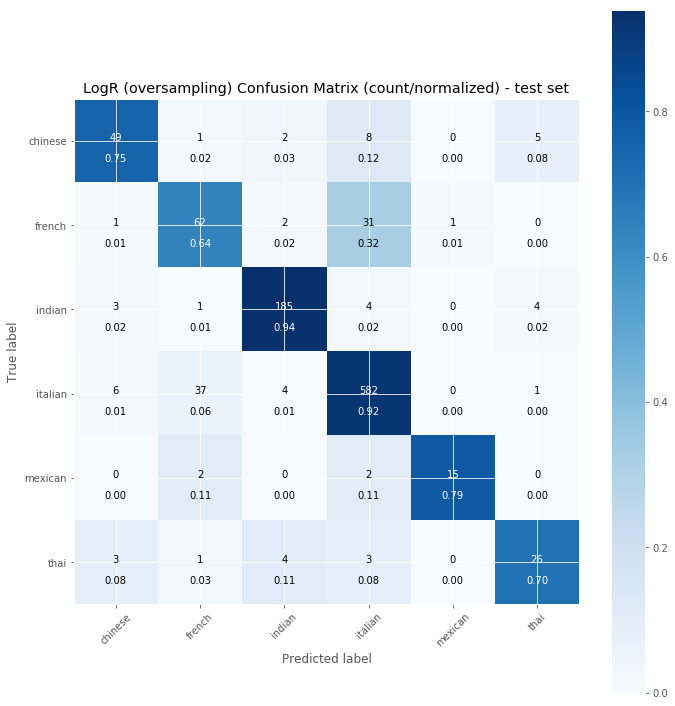

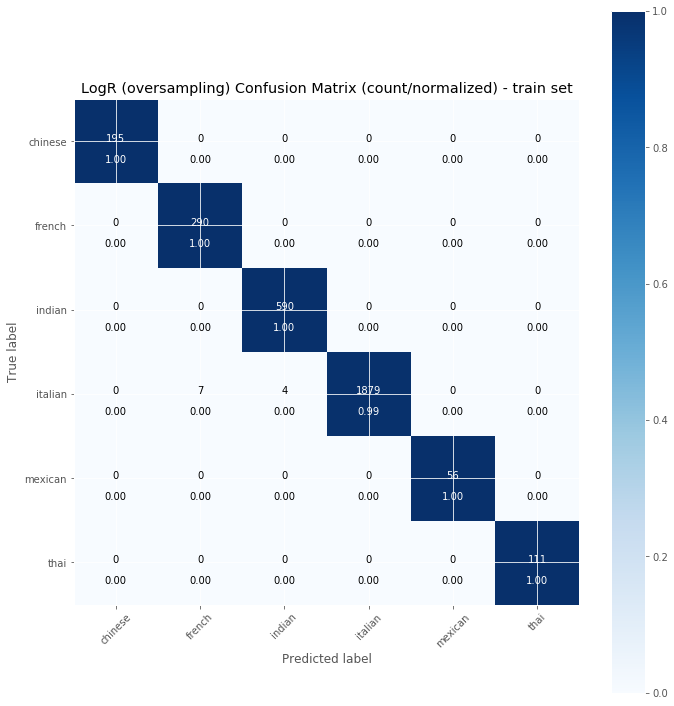

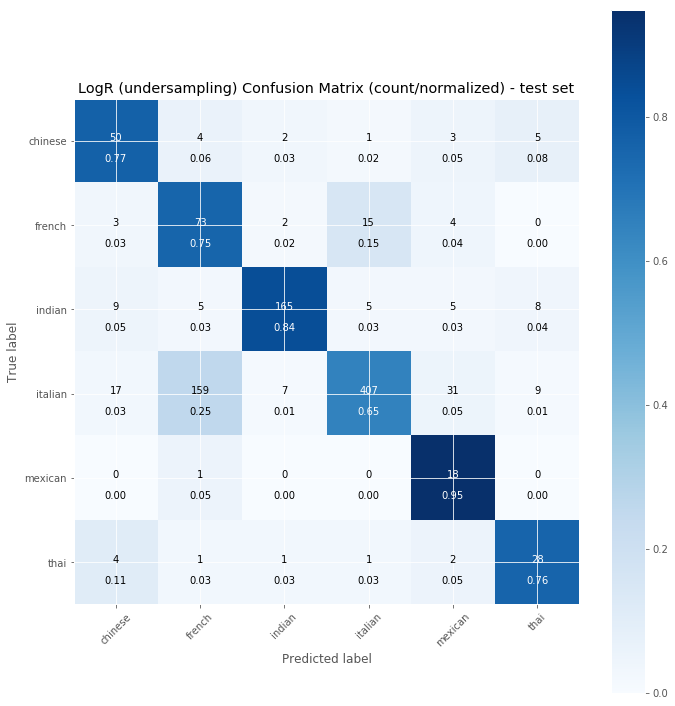

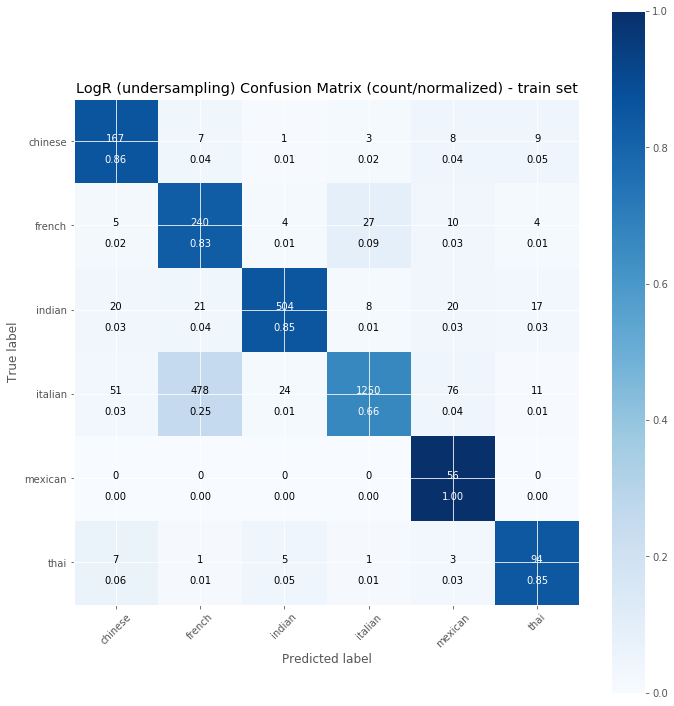

In [97]:

plot_confusion_matrix(cm_lr_os_test, classes=classes, normalize=True, title="LogR (oversampling) Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_os_train, classes=classes, normalize=True, title="LogR (oversampling) Confusion Matrix (count/normalized) - train set")


plot_confusion_matrix(cm_lr_us_test, classes=classes, normalize=True, title="LogR (undersampling) Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_lr_us_train, classes=classes, normalize=True, title="LogR (undersampling) Confusion Matrix (count/normalized) - train set")


### Results on Over and Undersampling
By comparison, oversampling did not make much difference except for reducing the Mexican score and French scores. Undersampling had the worst performance.

**Class Weight Scoring:** 

              precision    recall  f1-score   support

     chinese       0.85      0.78      0.82        65
      french       0.69      0.61      0.65        97
      indian       0.96      0.93      0.95       197
     italian       0.91      0.96      0.94       630
     mexican       0.93      0.68      0.79        19
        thai       0.82      0.73      0.77        37 
        
results on oversampling: 

                   pre       rec       spe        f1       geo       iba       sup

    chinese       0.78      0.82      0.98      0.80      0.90      0.79        65
     french       0.65      0.65      0.96      0.65      0.79      0.61        97
     indian       0.95      0.92      0.99      0.94      0.96      0.91       197
    italian       0.93      0.94      0.89      0.93      0.91      0.84       630
    mexican       0.88      0.79      1.00      0.83      0.89      0.77        19
       thai       0.77      0.73      0.99      0.75      0.85      0.70        37
       
results on undersampling:

                   pre       rec       spe        f1       geo       iba       sup

    chinese       0.59      0.82      0.96      0.68      0.89      0.77        65
     french       0.31      0.77      0.82      0.44      0.80      0.63        97
     indian       0.94      0.84      0.99      0.89      0.91      0.82       197
    italian       0.96      0.65      0.95      0.77      0.79      0.60       630
    mexican       0.33      0.95      0.96      0.49      0.96      0.91        19
       thai       0.51      0.73      0.97      0.60      0.84      0.69        37
       

## Calculating Chi-square (χ² )
Finally, calculating the Chi-square for the ingredient features and selecting the top K significant ones is another method to deal with overfitting on the training set.
The training scores went down slightly, but the test scores did not improve compared to the other models like Class Weighted Loss Function Logistic Regression.

In [98]:
def term_cuisine_count(term):
    '''
    that takes a word, and then counts how many times it occurs 
    for each of the classes
    returns a dictionary
    '''
    term_count_d = {}
    for recipe,cuisine in zip(X_train,y_train):

        if term in recipe:
            if cuisine in term_count_d.keys():
                term_count_d[cuisine] += 1
            else:
                term_count_d[cuisine] = 1
    return term_count_d

accuracy 0.8736842105263158
              precision    recall  f1-score   support

     chinese       0.84      0.72      0.78        65
      french       0.65      0.42      0.51        97
      indian       0.97      0.92      0.95       197
     italian       0.87      0.96      0.91       630
     mexican       1.00      0.58      0.73        19
        thai       0.82      0.76      0.79        37

    accuracy                           0.87      1045
   macro avg       0.86      0.73      0.78      1045
weighted avg       0.87      0.87      0.87      1045

[[ 47   0   1  13   0   4]
 [  0  41   2  54   0   0]
 [  1   1 182  12   0   1]
 [  4  20   1 604   0   1]
 [  0   1   0   7  11   0]
 [  4   0   1   4   0  28]]
results of using the LR model on the training data:
accuracy 0.9287994891443168
              precision    recall  f1-score   support

     chinese       0.98      0.90      0.94       195
      french       0.84      0.55      0.67       290
      indian       0.97

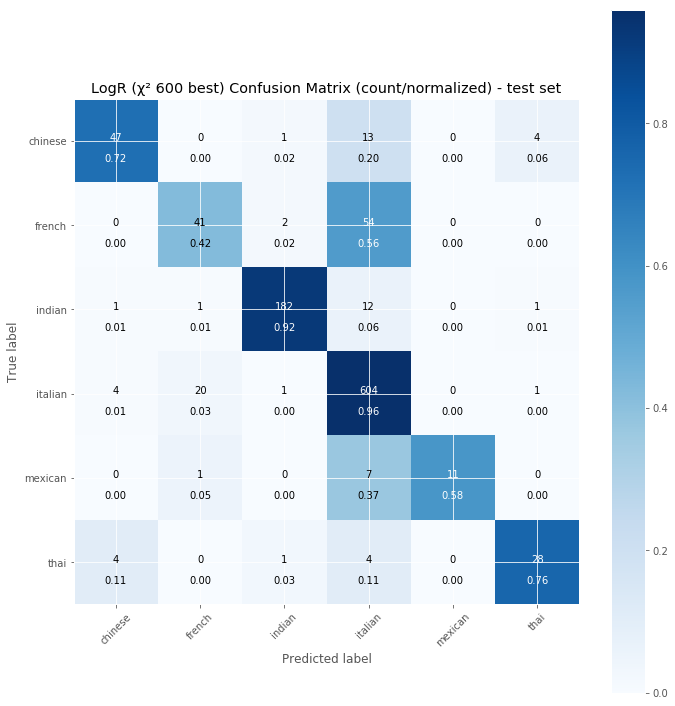

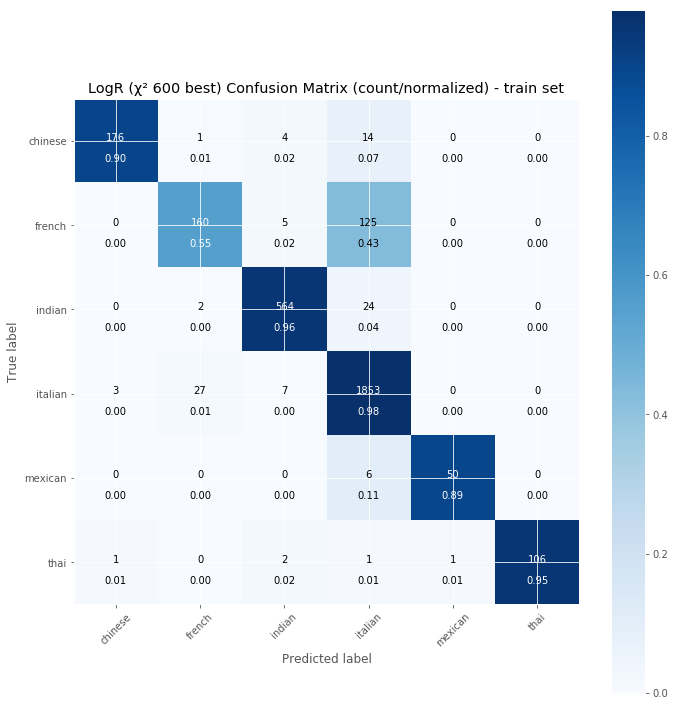

In [99]:
# this is another theory to the overfitting and try to deal with it this way

from sklearn.feature_selection import SelectKBest, chi2

vectorizer = CountVectorizer(ngram_range=(1, 2))

# tokenize and build vocab
matrix_train=vectorizer.fit_transform(X_train)
#vectorizer.fit(recipe_df['recipe_words'])
matrix_test=vectorizer.transform(X_test)


chi2score = chi2(matrix_train,y_train)[0]
 
wscores = zip(vectorizer.get_feature_names(),chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1], reverse=True) 



ch2 = SelectKBest(chi2, k=600)

X_chi_train = ch2.fit_transform(matrix_train,y_train)
X_chi_test = ch2.transform(matrix_test)
    


lr = LogisticRegression(max_iter=1000,random_state=123, multi_class='auto', solver='lbfgs')
lr.fit(X_chi_train,y_train)

y_pred = lr.predict(X_chi_test)


print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))#,target_names=cuisines))
cm_chi_test = confusion_matrix(y_test, y_pred)
print(cm_chi_test)

 

print("results of using the LR model on the training data:")
y_pred_train = lr.predict(X_chi_train)
print('accuracy %s' % accuracy_score(y_pred_train, y_train))
print(classification_report(y_train, y_pred_train))#,target_names=cuisines))
cm_chi_train = confusion_matrix(y_train, y_pred_train)
print(cm_chi_train)



plot_confusion_matrix(cm_chi_test, classes=classes, normalize=True, title="LogR (χ² 600 best) Confusion Matrix (count/normalized) - test set")
plot_confusion_matrix(cm_chi_train, classes=classes, normalize=True, title="LogR (χ² 600 best) Confusion Matrix (count/normalized) - train set")

print("ingredient words sorted by chi2 with class frequency\n")
index = 1
for term,chi2 in wchi2[:10]:
    print("{0} - {1}: {2}".format(index,term, chi2))
    result_d=term_cuisine_count(term)
    # sort the dictionary results by the count
    sorted_d = sorted(result_d.items(), key=lambda kv: kv[1], reverse=True)
    print(sorted_d)
    print(sorted_d[0][0])
#     if sorted_d[0][0] == 'french':
#         break
    index += 1

## Summary Table
*Note: There could be slight variation with these F1 scores to what is rendered in the notebook.*    
<table>
<tbody>
  <tr>
    <th td style="text-align: center;" colspan="8">Model Results</th>
  </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>
  <tr>
    <td>Count</td>
    <td>260</td>
    <td>387</td>
    <td>787</td>
    <td>2520</td>
    <td>75</td>
    <td>148</td>
  </tr>
    <tr>  
 <th td style="text-align: center;" colspan="8">Multinomial Logistic Regression (MLR)</th>
      </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>

  <tr>
    <td><br>Test F1 score<br></td>
    <td>0.81</td>
    <td>0.58</td>
    <td>0.95</td>
    <td>0.93</td>
    <td>0.69</td>
    <td>0.76</td>
  </tr>
  <tr>
    <td>Train F1 score<br></td>
    <td>1.0</td>
    <td>0.98</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>0.99</td>
    <td>1.0</td>
  </tr>
  <tr>
    <th td style="text-align: center;" colspan="8">Class Weighted Loss Function (MLR)</th>
  </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>
  <tr>
    <td>Test F1 score</td>
    <td>0.82</td>
    <td>0.65</td>
    <td>0.95</td>
    <td>0.94</td>
    <td>0.79</td>
    <td>0.77</td>
  </tr>
  <tr>
    <td>Train F1 score</td>
    <td>1.0</td>
    <td>0.99</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
  </tr>
  <tr>
    <th td style="text-align: center;" colspan="8">Undersampling (MLR)</th>
  </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>
  <tr>
    <td>Test F1 score</td>
    <td>0.68</td>
    <td>0.44</td>
    <td>0.89</td>
    <td>0.77</td>
    <td>0.49</td>
    <td>0.60</td>
  </tr>
  <tr>
    <td>Train F1 score</td>
    <td>0.93</td>
    <td>0.80</td>
    <td>0.91</td>
    <td>0.84</td>
    <td>0.99</td>
    <td>0.92</td>
  </tr>
  <tr>       
    <th td style="text-align: center;" colspan="8">Oversampling (MLR)</th>
  </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>
  <tr>
    <td>Test F1 score</td>
    <td>0.80</td>
    <td>0.65</td>
    <td>0.94</td>
    <td>0.93</td>
    <td>0.83</td>
    <td>0.75</td>
  </tr>
  <tr>
    <td>Train F1 score</td>
    <td>1.0</td>
    <td>0.98</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
  </tr>
  <tr>     
    <th td style="text-align: center;" colspan="8">CHI Score (top 600)</th>
  </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>
  <tr>    
    <td>Test F1 score</td>
    <td>0.76</td>
    <td>0.46</td>
    <td>0.94</td>
    <td>0.91</td>
    <td>0.73</td>
    <td>0.72</td>
  </tr>
  <tr>
    <td>Train F1 score</td>
    <td>0.89</td>
    <td>0.62</td>
    <td>0.96</td>
    <td>0.94</td>
    <td>0.93</td>
    <td>0.93</td>
  </tr>
  <tr>
    <th td style="text-align: center;" colspan="8">Deep Learning w/ Keras - densely connected network</th>
  </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>
  <tr>
    <td>Test F1 score</td>
    <td>0.71</td>
    <td>0.54</td>
    <td>0.92</td>
    <td>0.94</td>
    <td>0.47</td>
    <td>0.57</td>
  </tr>
  <tr>
    <td>Train F1 score</td>
    <td>0.99</td>
    <td>0.99</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
  </tr>
  <tr>
    <th td style="text-align: center;" colspan="8">Deep Learning w/ Keras - Multichannel n-gram with embedding and Conv1D</th>
  </tr>
  <tr>
    <td>Cuisine</td>
    <td>Chinese</td>
    <td>French</td>
    <td>Indian</td>
    <td>Italian</td>
    <td>Mexican</td>
    <td>Thai</td>
  </tr>
  <tr>
    <td>Test F1 score</td>
    <td>0.72</td>
    <td>0.49</td>
    <td>0.91</td>
    <td>0.97</td>
    <td>0.74</td>
    <td>0.73</td>
  </tr>
  <tr>
    <td>Train F1 score</td>
    <td>0.98</td>
    <td>0.99</td>
    <td>0.99</td>
    <td>0.99</td>
    <td>0.98</td>
    <td>0.98</td>
  </tr>
    </tbody>
</table>

- Class Weighted had top scores for Chinese, French, Indian
- Italian did the best with Conv1D and multigram embedding, followed by Class Weighted.
- Mexican did best with oversampling, followed by Class Weighted.

The overall best model, that I go with for the AWS deployment will be Class weighted loss function.

Other ideas in addition to collecting more data is considering the quantity of an ingredient as part of the feature weight.




## Appendix


Here are two implemented two Deep Learning architectures.  Code and results are below and scores are summarized in the summary table above.


### Deep Learning with Keras - densely connected network
Uses the tokenized words.
French F1 score .72, the best out of all, including the second DL implementation.

The validation score wavered after 3 Epochs. Early stopping would save the state of the model at that point.

In [100]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import layers
from keras import callbacks

# callbacks_list = [
#         callbacks.EarlyStopping(
#             monitor='acc',
#             patience=1,
#         ),
#         callbacks.ModelCheckpoint(
#             filepath='dense_model',
#             monitor='val_loss',
#             save_best_only=True,
# )]
   
max_words = 1864

tokenize = Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(X_train)

X_train_t = tokenize.texts_to_matrix(X_train)
X_test_t = tokenize.texts_to_matrix(X_test)
vocab_size = len(tokenize.word_index) + 1  # Adding 1 because of reserved 0 index


encoder = LabelEncoder()
encoder.fit(y_train)
y_train_t = encoder.transform(y_train)
y_test_t = encoder.transform(y_test)

num_classes = np.max(y_train_t) + 1
y_train_t = utils.to_categorical(y_train_t, num_classes)
y_test_t = utils.to_categorical(y_test_t, num_classes)

print('x_train shape:', X_train_t.shape)
print('x_test shape:', X_test_t.shape)
print('y_train shape:', y_train_t.shape)
print('y_test shape:', y_test_t.shape)

batch_size = 100
epochs = 15


# Build the model
model = Sequential()
model.add(layers.Dense(512, activation='relu',input_shape=(vocab_size,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
plot_model(model, show_shapes=True, to_file='dense_dl.png')

x_train shape: (3132, 1864)
x_test shape: (1045, 1864)
y_train shape: (3132, 6)
y_test shape: (1045, 6)


In [101]:


history = model.fit(X_train_t, y_train_t,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_t, y_test_t),
                   class_weight = 'auto')#,
#                    callbacks=callbacks_list)
y_pred_t=model.predict(X_test_t)
# .88 without class weights

y_pred_train=model.predict(X_train_t)


Train on 3132 samples, validate on 1045 samples
Epoch 1/15
3132/3132 [==============================] - 8s 3ms/step - loss: 0.8497 - acc: 0.7181 - val_loss: 0.4851 - val_acc: 0.8392
Epoch 2/15
3132/3132 [==============================] - 7s 2ms/step - loss: 0.3372 - acc: 0.8854 - val_loss: 0.3391 - val_acc: 0.8909
Epoch 3/15
3132/3132 [==============================] - 7s 2ms/step - loss: 0.1750 - acc: 0.9432 - val_loss: 0.3166 - val_acc: 0.8976
Epoch 4/15
3132/3132 [==============================] - 7s 2ms/step - loss: 0.0987 - acc: 0.9709 - val_loss: 0.3282 - val_acc: 0.9005
Epoch 5/15
3132/3132 [==============================] - 7s 2ms/step - loss: 0.0602 - acc: 0.9831 - val_loss: 0.3546 - val_acc: 0.8909
Epoch 6/15
3132/3132 [==============================] - 6s 2ms/step - loss: 0.0422 - acc: 0.9891 - val_loss: 0.3832 - val_acc: 0.8986
Epoch 7/15
3132/3132 [==============================] - 6s 2ms/step - loss: 0.0330 - acc: 0.9901 - val_loss: 0.3874 - val_acc: 0.8928
Epoch 8/15
313

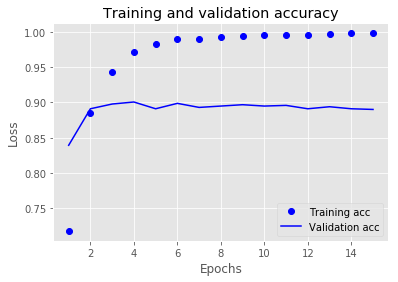

In [102]:
history_dict = history.history
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(history_dict['acc']) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1045/1045 [==============================] - 1s 682us/step
Test accuracy: 0.8899521533952376


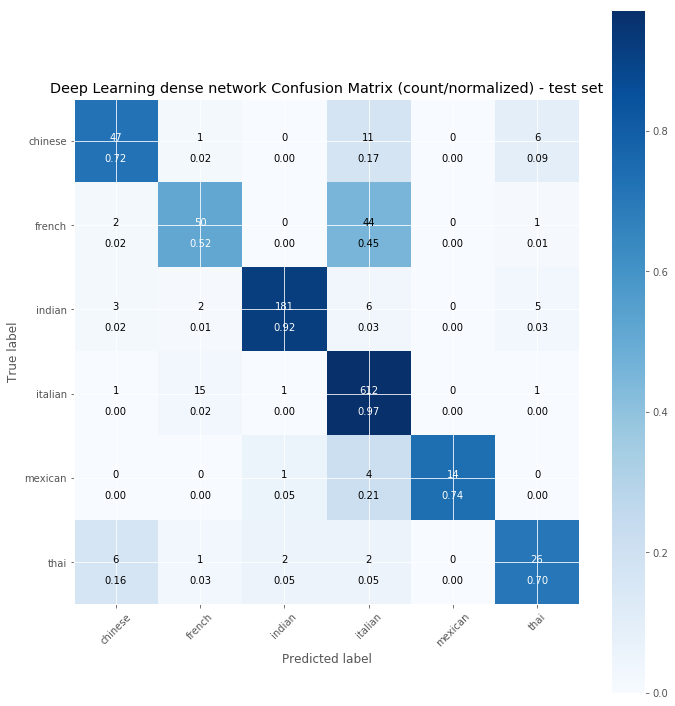

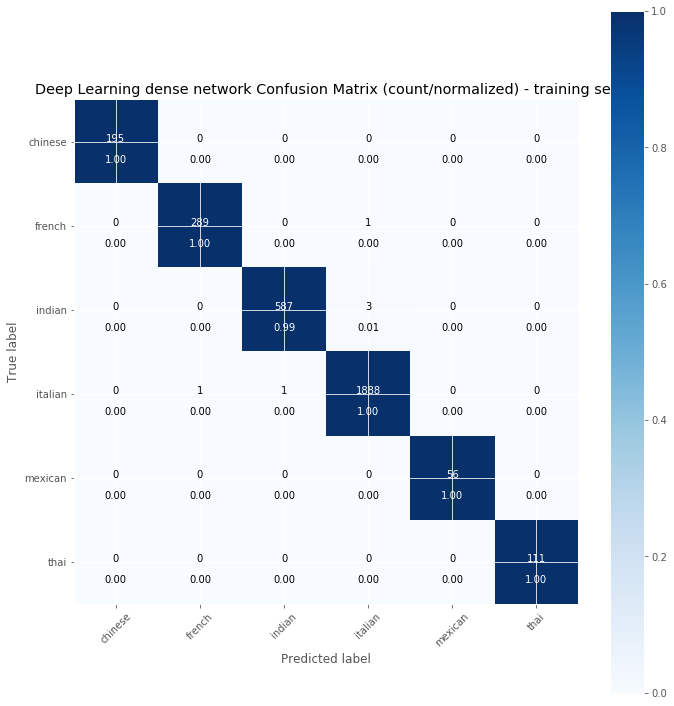

In [103]:
score = model.evaluate(X_test_t, y_test_t,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

matrix = confusion_matrix(y_test_t.argmax(axis=1), y_pred_t.argmax(axis=1))
    

matrix_train = confusion_matrix(y_train_t.argmax(axis=1), y_pred_train.argmax(axis=1))

import itertools


plot_confusion_matrix(matrix, classes=['chinese', 'french','indian','italian','mexican','thai' ], normalize=True, title="Deep Learning dense network Confusion Matrix (count/normalized) - test set")

plot_confusion_matrix(matrix_train, classes=['chinese', 'french','indian','italian','mexican','thai' ], normalize=True, title="Deep Learning dense network Confusion Matrix (count/normalized) - training set")

### Deep Learning with Keras - Multichannel n-gram with embedding and Conv1D
I wanted to try using bigrams to see how much difference that would make. I found an [implementation here] (https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/) that I used as a guide for my code below.
I didnt think RNN will do much, like word2vec, because the order of ingredients is irrelevant to the cuisine.

Using 3 grams didn't give much lift vs only 1 and 2 grams. This architecture did not do as well, overall, as the simpler DL model above.

In [104]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils.vis_utils import plot_model
from numpy import array

# define the model
def define_model(length, vocab_size):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100)(inputs1) 
#returns 3D tensor of shape(samples, sequence_ length, embedding_dimensionality)
	conv1 = Conv1D(filters=32, kernel_size=1, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, 100)(inputs2)
	conv2 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
# 	inputs3 = Input(shape=(length,))
# 	embedding3 = Embedding(vocab_size, 100)(inputs3)
# 	conv3 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding3)
# 	drop3 = Dropout(0.5)(conv3)
# 	pool3 = MaxPooling1D(pool_size=2)(drop3)
# 	flat3 = Flatten()(pool3)
	# merge
# 	merged = concatenate([flat1, flat2, flat3])
	merged = concatenate([flat1, flat2])
	# interpretation
	dense1 = Dense(10, activation='relu')(merged)
# 	outputs = Dense(6, activation='sigmoid')(dense1)
	outputs = Dense(6, activation='softmax')(dense1) #99/85 better than sigmoid
# 	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	print(model.summary())
	plot_model(model, show_shapes=True, to_file='embed_conv_2channel.png')
	return model

In [105]:

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])
 
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences - for the embedding layer
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded
#     return encoded


# create tokenizer
tokenizer = create_tokenizer(X_train)
# calculate max document length
length = max_length(X_train)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, X_train, length)
testX = encode_text(tokenizer, X_test, length)



print(trainX.shape, testX.shape)
 

# define model
model = define_model(length, vocab_size)

callbacks_list = [
        callbacks.EarlyStopping(
            monitor='acc',
            patience=1,
        ),
        callbacks.ModelCheckpoint(
            filepath='dense_model',
            monitor='val_loss',
            save_best_only=True,
 )]
#     callbacks.TensorBoard(
#         log_dir='log_dir',
#         histogram_freq=1,
#         embeddings_freq=1,
# ]

    
# fit model
# model.fit([trainX,trainX,trainX], array(y_train_t), epochs=10, batch_size=16)
model.fit([trainX,trainX], array(y_train_t), epochs=15, 
          batch_size=16,
         validation_data=([testX,testX], y_test_t),
         callbacks=callbacks_list)
# batch size 16 gives the best results
# model.save('model.h5')
 
# evaluate model on training dataset
# loss, acc = model.evaluate([trainX,trainX,trainX], array(y_train_t), verbose=0)
loss, acc = model.evaluate([trainX,trainX], array(y_train_t), verbose=0)
print('Train Accuracy: %f' % (acc*100))
 
# evaluate model on test dataset dataset
loss, acc = model.evaluate([testX,testX],array(y_test_t), verbose=0)
# loss, acc = model.evaluate([testX,testX,testX],array(y_test_t), verbose=0)
print('Test Accuracy: %f' % (acc*100))





Max document length: 58
Vocabulary size: 1864
(3132, 58) (1045, 58)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 58, 100)      186400      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 58, 100)      186400      input_4[0][0]                    
_________________________________________

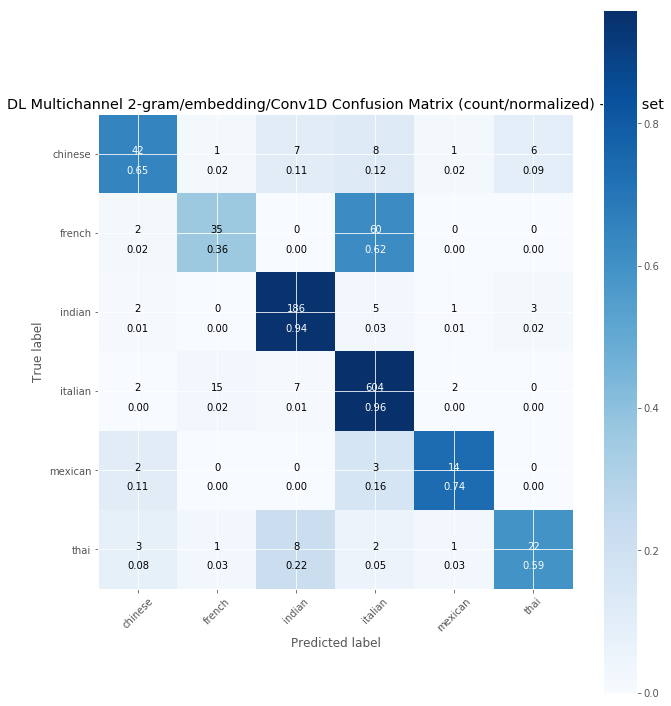

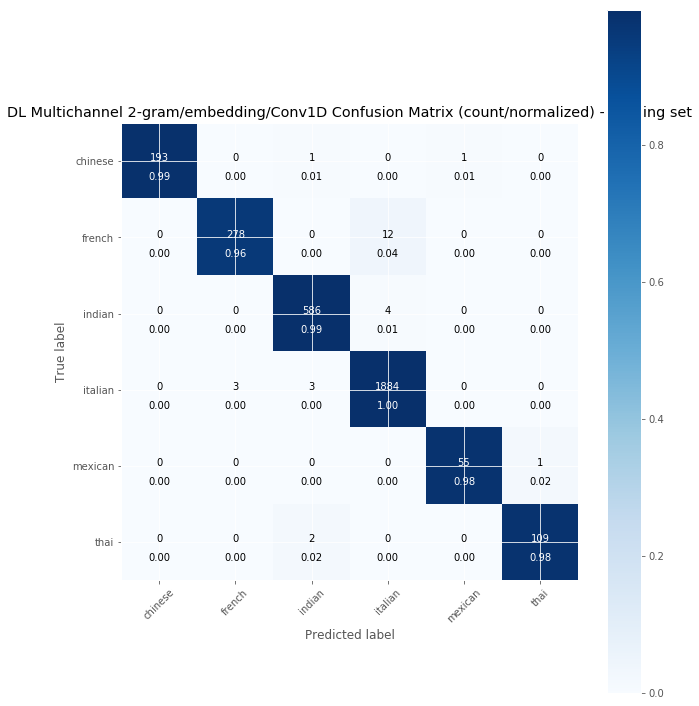

In [106]:
y_pred_t=model.predict([testX,testX])
# y_pred_t=model.predict([testX,testX,testX])
y_pred_train=model.predict([trainX,trainX])
matrix = confusion_matrix(y_test_t.argmax(axis=1), y_pred_t.argmax(axis=1))
matrix_train = confusion_matrix(y_train_t.argmax(axis=1), y_pred_train.argmax(axis=1))
 
plot_confusion_matrix(matrix, classes=['chinese', 'french','indian','italian','mexican','thai' ], normalize=True, title="DL Multichannel 2-gram/embedding/Conv1D Confusion Matrix (count/normalized) - test set")


plot_confusion_matrix(matrix_train, classes=['chinese', 'french','indian','italian','mexican','thai' ], normalize=True, title="DL Multichannel 2-gram/embedding/Conv1D Confusion Matrix (count/normalized) - training set")

### Would more data help with class imbalance?
Below is an experiment to test whether getting more data to balance the classes could make a difference.  This is can be an important metric to quantify if getting more data is time consuming or expensive. It was not clear based on the results to deal with class imbalance in the first part of this notebook.

Below, I plot what the test and training scores are, for each cuisine.  The class sizes start at 25 and continue in increments of 25.  If the size is less then the class count, then it is downsampled to set them all equal.  This is the case until the count goes over the class size. The code that created the graphs are in the cell below. (if the image does not render, view the file experiment.png)

![title](experiment.png) 
Vertical colored lines mark the max class count on the x axis.
Thai, Mexican and Indian do the best with a class count of 50. They both fluctuate at a lower range, and Mexican dips down towards the high end of the count. Indian starts to go up in as the class count increases. French does the best at 50 and 75, and then starts to go downwards. Italian is not what I expected - it should be in the higher range of .9, and I could have a bug in the code below.
Though this experiment didn't help to show if collecting more data would be helpful, the results of all of the other attempts in this notebook show that collecting more data is the last choice left.

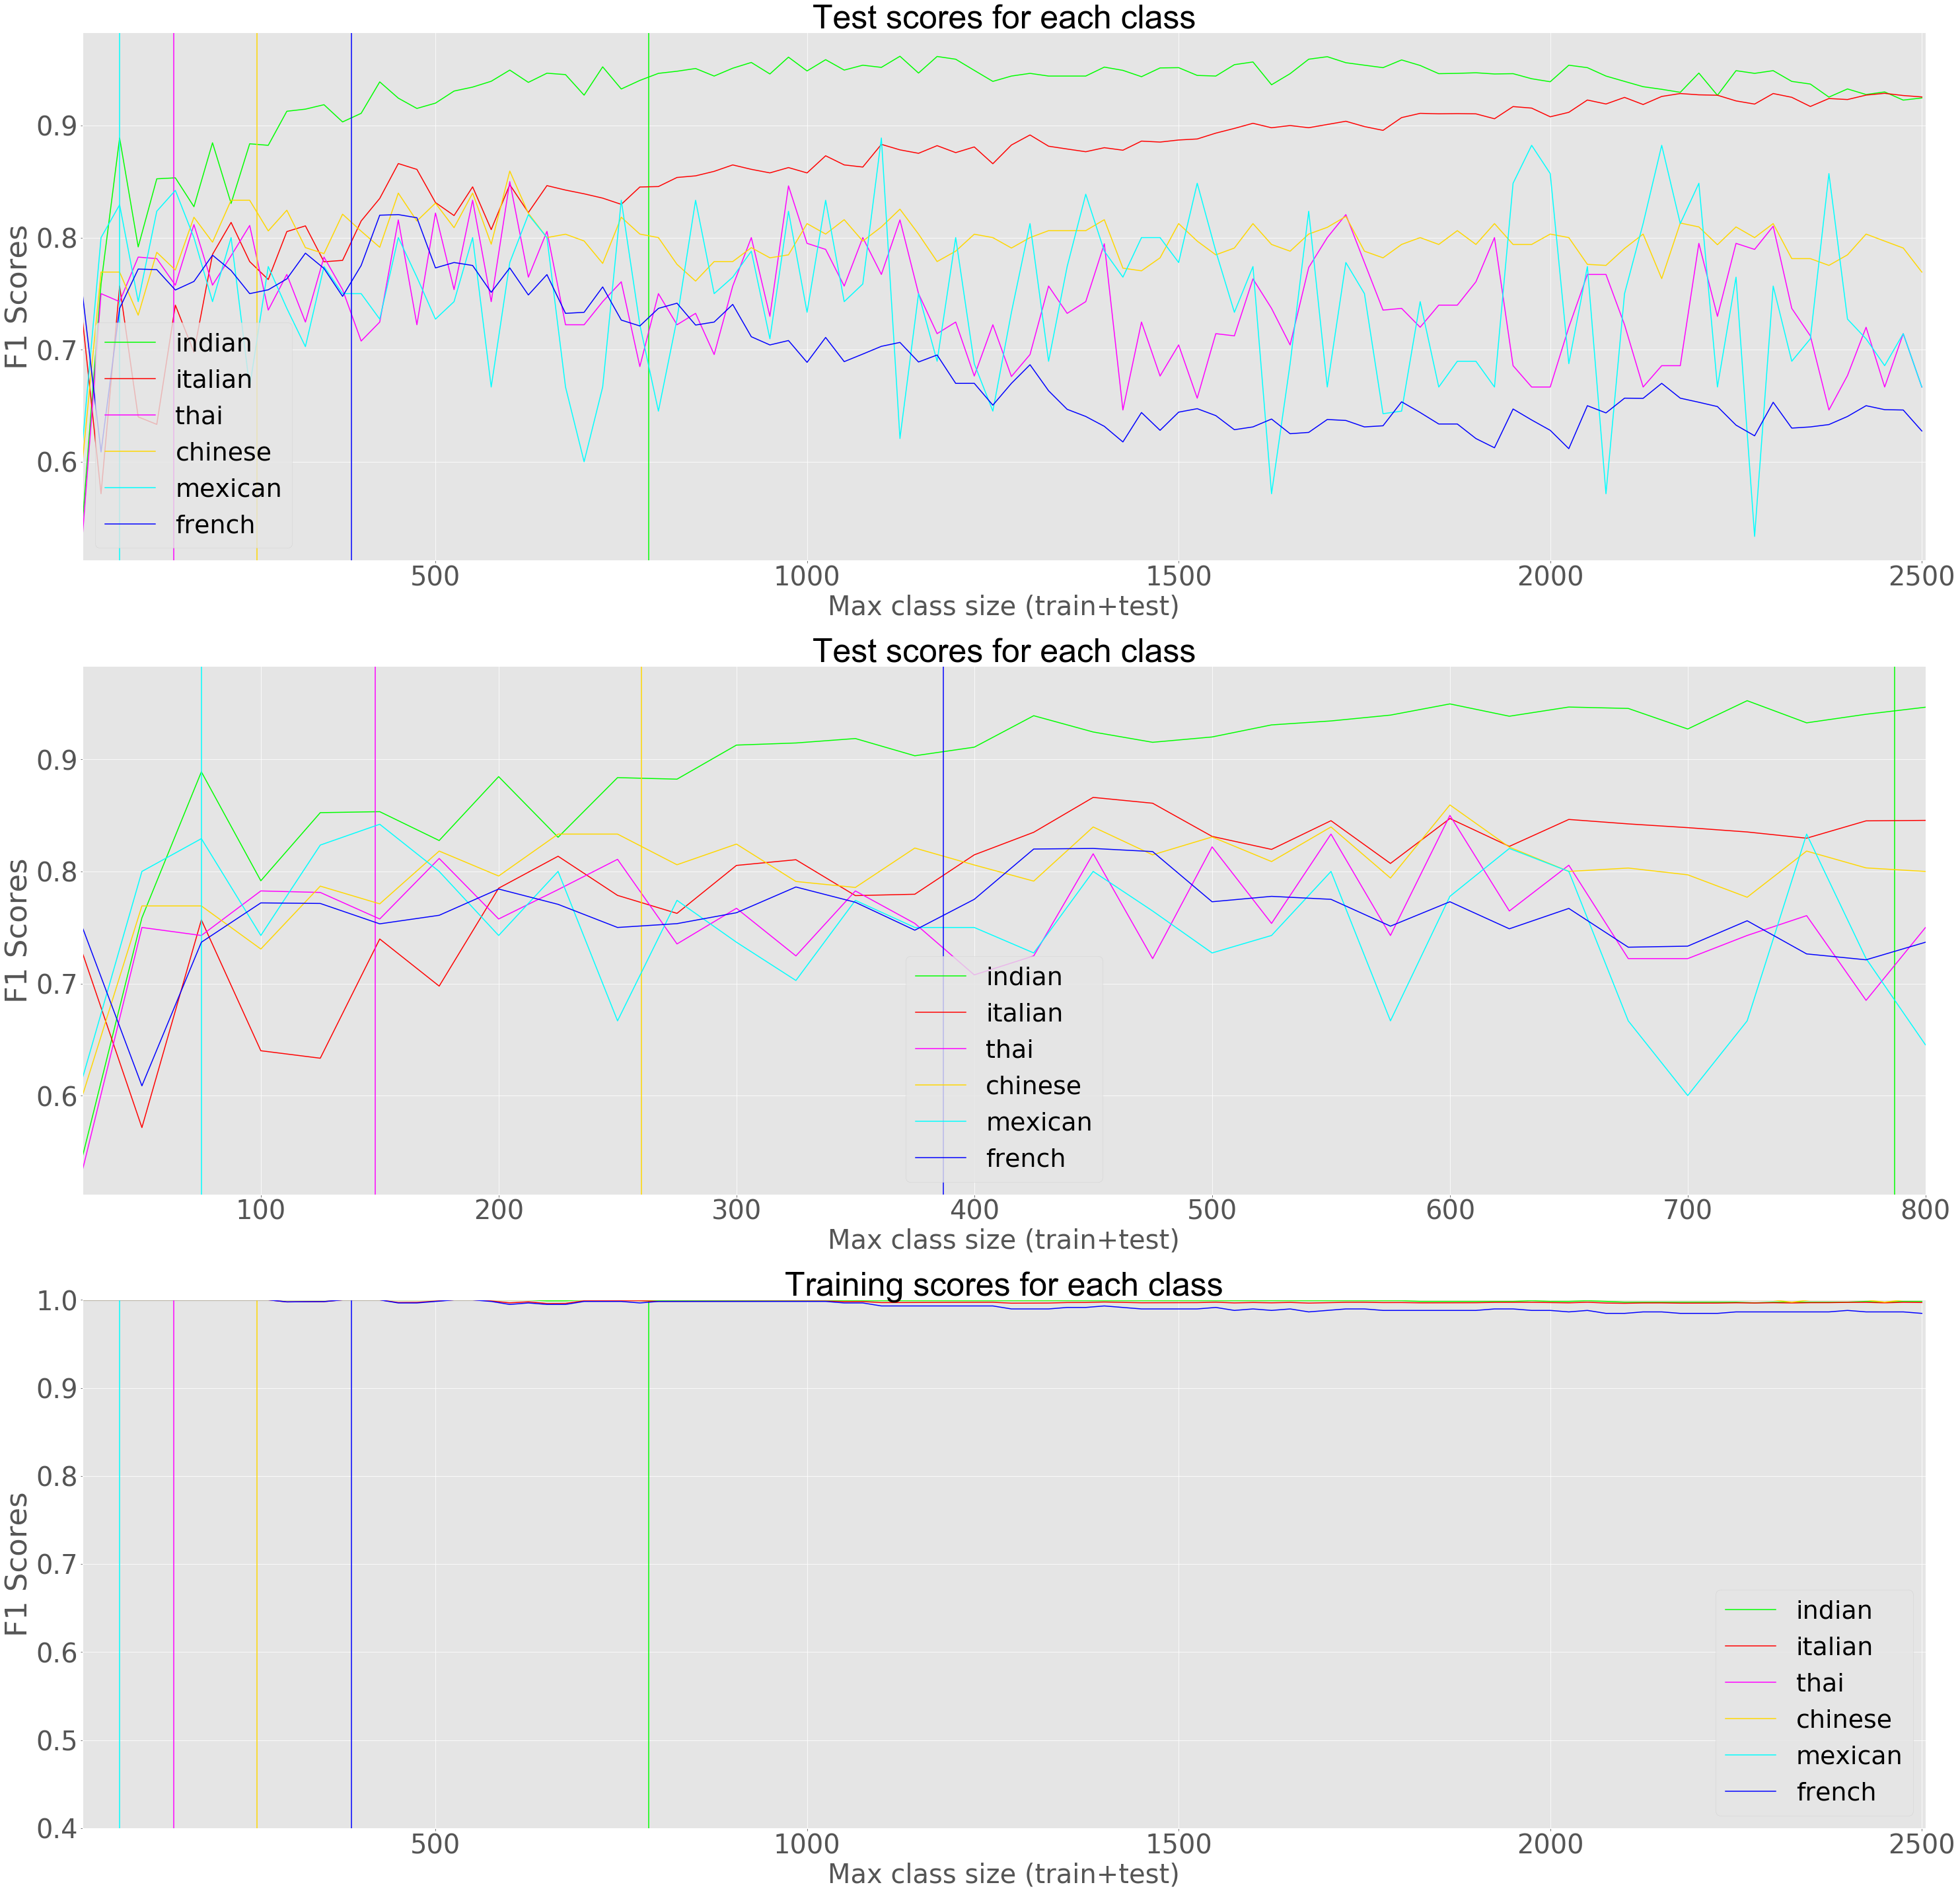

In [107]:
from sklearn.utils import resample

# create a dictionary, to pandas dataframe, to randomly sample by a fixed size

recipe_dict = {'recipe_words':recipe_strings, 'cuisine':cuisine_labels}

recipe_df = pd.DataFrame(recipe_dict, columns=['recipe_words','cuisine'])

cuisines=list(cuisine_counts.keys())
counts=list(cuisine_counts.values())
#put markers in the plot where class is less than x value?
    
def set_equal_class_count(recipe_df, n_samples):
    df_list = []
    for cuisine in cuisines:
        cuisine_df=recipe_df[recipe_df.cuisine==cuisine]
        #print(len(cuisine_df))
        #dont downsample if the cuisine has less than n_samples
        if len(cuisine_df)>n_samples:
            df_downsampled = resample(recipe_df[recipe_df.cuisine==cuisine], 
                                     replace=False,    # sample without replacement
                                     n_samples=n_samples,     # to match minority class
                                     random_state=123) # reproducible results
            df_list.append(df_downsampled)
        else:
            df_list.append(cuisine_df)
            
    
    df_downsampled = pd.concat(df_list)
    return df_downsampled



def lr_run(X,y, cuisines):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, stratify=y, random_state=123)

    vectorizer = CountVectorizer(ngram_range=(1, 2))

    # tokenize and build vocab
    matrix_train=vectorizer.fit_transform(X_train)
    matrix_test=vectorizer.transform(X_test)
    #lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    lr_balance.fit(matrix_train, y_train)

    y_pred = lr_balance.predict(matrix_test)


    f1_test=[]
    f1_train=[]
 
    # using the dictionary output so I can access the f1 scores for plotting
    test_report=classification_report(y_test, y_pred, output_dict=True)
    #pprint.pprint(test_report)#,target_names=cuisines))
    #print(confusion_matrix(y_test, y_pred))
#     print("Size of the train set: {0}".format(len(y_train)))
#     print("Size of the test set: {0}".format(len(y_test)))

 
    #pp.pprint(test_report)
    #print("results of using the LR model on the training data:")
    y_pred_train = lr_balance.predict(matrix_train)

    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    #pp.pprint(train_report)#,target_names=cuisines))
    #print(confusion_matrix(y_train, y_pred_train))
    for c in cuisines:
#         print(c)
        #print(train_report[c]['f1-score'])
        f1_test.append(test_report[c]['f1-score'])
        f1_train.append(train_report[c]['f1-score'])
        
    return f1_test, f1_train

#create list of class sizes, which will be the train and test, max will be max class, 
data_sizes=list(np.arange(25,int(max(counts)), 25))

f1_test_scores=[] #list of lists of f1 scores for each cuisine and data size
f1_train_scores=[] #list of lists of f1 scores for each cuisine and data size

for size in data_sizes:
    df_downsampled=set_equal_class_count(recipe_df, size.item())

    f1_test, f1_train=lr_run(df_downsampled['recipe_words'], df_downsampled['cuisine'], cuisines)
    f1_test_scores.append(f1_test)
    f1_train_scores.append(f1_train)


fig, axes = plt.subplots(3, 1, figsize=(50,50))

axes[0].set_xlabel('Max class size (train+test)', fontsize=40)
axes[0].set_ylabel("F1 Scores", fontsize=45)
axes[0].set_title('Test scores for each class', fontname="Arial", fontsize=50)
axes[0].tick_params(axis = 'both', which = 'major', labelsize = 40)
axes[0].set_xlim(left=data_sizes[0], right=data_sizes[-1]+5)
 
colors=['lime','red','magenta', 'gold','cyan', 'blue']

for i in range(len(cuisines)):
    axes[0].plot(data_sizes,[pt[i] for pt in f1_test_scores],label = cuisines[i], color=colors[i])
    #put in vertical lines for cuisine class size
    axes[0].axvline(x=counts[i],color=colors[i])
axes[0].legend(fontsize=38)

#same as above but zoom in on the X axis
axes[1].set_xlabel('Max class size (train+test)', fontsize=40)
axes[1].set_ylabel("F1 Scores", fontsize=45)
axes[1].set_title('Test scores for each class', fontname="Arial", fontsize=50)
axes[1].tick_params(axis = 'both', which = 'major', labelsize = 40)
axes[1].set_xlim(left=data_sizes[0], right=800)

colors=['lime','red','magenta', 'gold','cyan', 'blue']

for i in range(len(cuisines)):
    axes[1].plot(data_sizes,[pt[i] for pt in f1_test_scores],label = cuisines[i], color=colors[i])
    #put in vertical lines for cuisine class size
    axes[1].axvline(x=counts[i],color=colors[i])
axes[1].legend(fontsize=38)


#plot the train scores to visualize
axes[2].set_xlabel('Max class size (train+test)', fontsize=40)
axes[2].set_ylabel("F1 Scores", fontsize=45)
axes[2].set_title('Training scores for each class', fontname="Arial", fontsize=50)
axes[2].tick_params(axis = 'both', which = 'major', labelsize = 40)
axes[2].set_xlim(left=data_sizes[0], right=data_sizes[-1]+5)
axes[2].set_ylim([0.4, 1.0]) #to match the test y range
colors=['lime','red','magenta', 'gold','cyan', 'blue']

for i in range(len(cuisines)):
    axes[2].plot(data_sizes,[pt[i] for pt in f1_train_scores],label = cuisines[i], color=colors[i])
    #put in vertical lines for cuisine class size
    axes[2].axvline(x=counts[i],color=colors[i])
axes[2].legend(fontsize=38)